# Model building recommender system uses TF-IDF to vectorize game tags.

In [1]:
pip install gdown

In [2]:
pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552449 sha256=994a76e99503bb96e005a1fde7dfd0339208be8a7ba8f9db8729b3cfcee74da6
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [3]:
pip install wordcloud

In [11]:
# imports
import gdown
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from annoy import AnnoyIndex
from sklearn.preprocessing import normalize
from IPython.display import display
from sklearn.metrics import precision_score, recall_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
# downloading a file
file_id = '11SQ7kKA4MslkNrF6eq7u0sm541i1WH7d'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'sampled_data.csv'

gdown.download(url, output, quiet=False)

sampled_data = pd.read_csv(output)
sampled_data.head()

Downloading...
From (original): https://drive.google.com/uc?id=11SQ7kKA4MslkNrF6eq7u0sm541i1WH7d
From (redirected): https://drive.google.com/uc?id=11SQ7kKA4MslkNrF6eq7u0sm541i1WH7d&confirm=t&uuid=356c5eeb-a954-4930-bacf-833aca7b567f
To: /content/sampled_data.csv
100%|██████████| 247M/247M [00:01<00:00, 159MB/s]


,app_id,tags_string,user_id,title,rating_numeric
0,951440,"Open World Survival Craft, Survival, Open Worl...",9074881,Volcanoids,4.5
1,32440,"LEGO, Local Co-Op, Adventure, Co-op, Family Fr...",6006822,LEGO® Star Wars™ - The Complete Saga,5.0
2,615610,"Indie, Casual, Action, Space, 2D, Singleplayer...",1239,Orbt XL,5.0
3,1097840,"Action, Adventure, Multiplayer, Third-Person S...",9255103,Gears 5,3.5
4,464060,"Cyberpunk, Action, Top-Down Shooter, Great Sou...",5324004,RUINER,4.5


In [6]:
content_df = sampled_data [['user_id', 'app_id', 'title', 'tags_string']]
content_df.head()

,user_id,app_id,title,tags_string
0,9074881,951440,Volcanoids,"Open World Survival Craft, Survival, Open Worl..."
1,6006822,32440,LEGO® Star Wars™ - The Complete Saga,"LEGO, Local Co-Op, Adventure, Co-op, Family Fr..."
2,1239,615610,Orbt XL,"Indie, Casual, Action, Space, 2D, Singleplayer..."
3,9255103,1097840,Gears 5,"Action, Adventure, Multiplayer, Third-Person S..."
4,5324004,464060,RUINER,"Cyberpunk, Action, Top-Down Shooter, Great Sou..."


In [7]:
def preprocess_tags(tags):
    # removing special characters and converting to lower case
    tags = re.sub(r'[^\w\s]', '', tags).lower()
    return tags

In [8]:
content_df['tags_string'] = content_df['tags_string'].fillna('').apply(preprocess_tags)

<ipython-input-8-20d8dd7235d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['tags_string'] = content_df['tags_string'].fillna('').apply(preprocess_tags)


In [14]:
# separating tags and collecting them into one list
all_tags = ' '.join(content_df['tags_string']).split()
unique_tags = set(all_tags)
tag_counts = Counter(all_tags)

# tag information output
print(f'Total unique tags: {len(unique_tags)}')
print(f'Unique tags: {unique_tags}')
print(f'Frequency of occurrence of tags: {tag_counts}')

Total unique tags: 483
Unique tags: {'textbased', 'cult', 'tutorial', 'snow', 'music', 'lorerich', 'moba', 'satire', 'epic', 'offroad', 'football', 'typing', 'video', 'production', 'lego', 'protagonist', 'politics', 'unforgiving', 'lgbtq', 'steampunk', 'cute', 'dating', 'hex', 'tabletop', 'narrative', 'open', 'photo', 'classbased', 'pinball', 'travel', 'dragons', 'space', 'and', 'documentary', 'controller', 'western', 'movement', 'on', 'pool', 'beat', 'click', 'life', 'adventure', 'parody', 'mars', 'atv', 'mystery', 'manipulation', 'jet', 'inventory', 'werewolves', 'attack', 'motorbike', 'slash', 'gun', 'card', 'games', 'time', 'mouse', 'diplomacy', 'spectacle', 'zombies', 'linear', 'multiplayer', 'funny', 'actionadventure', 'driving', 'quicktime', 'teambased', 'submarine', '25d', 'motocross', 'defense', 'perma', 'auto', 'fishing', 'idler', 'events', 'cats', 'development', 'play', 'scroller', 'simulator', 'thriller', 'casual', 'steam', 'creature', 'blood', 'battle', '8bit', 'player', '

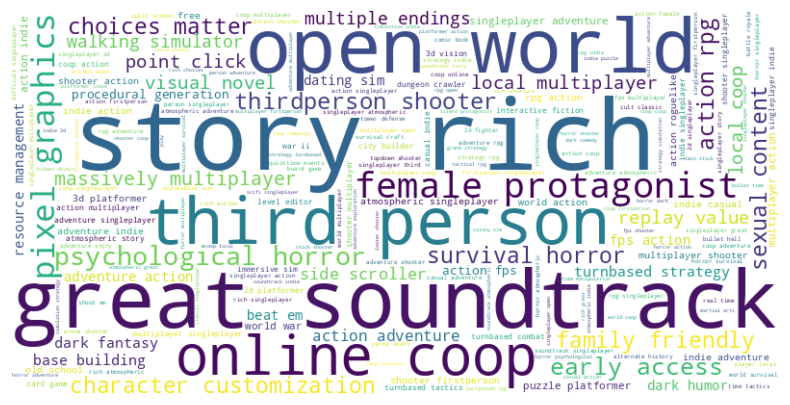

In [12]:
# creating a string of all descriptions
tags_text = ' '.join(content_df['tags_string'])
# word cloud creation
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
# converting tags to TF-IDF vector representation
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(content_df['tags_string'])

In [15]:
# TF-IDF matrix normalization
tfidf_matrix = normalize(tfidf_matrix)

In [16]:
# vector dimension
f = tfidf_matrix.shape[1]

In [17]:
# Annoy index creation
index = AnnoyIndex(f, 'angular')

In [18]:
for i in range(tfidf_matrix.shape[0]):
    index.add_item(i, tfidf_matrix[i].toarray()[0])

In [19]:
# building a tree
index.build(10)

True

In [20]:
train_df, test_df = train_test_split(content_df, test_size=0.2, random_state=42)

In [21]:
def get_recommendations_for_user(user_id, content_df=content_df, index=index, tfidf_matrix=tfidf_matrix, top_n=10):
    # games that the user has already played
    user_games = content_df[content_df['user_id'] == user_id]
    user_game_indices = user_games.index
    user_game_vectors = [tfidf_matrix[i].toarray()[0] for i in user_game_indices]

    # collecting all recommendations for games that the user has already played
    recommended_indices = set()
    for vector in user_game_vectors:
        recommended_indices.update(index.get_nns_by_vector(vector, top_n * 2))

    # exclude games that the user has already played
    recommended_indices.difference_update(user_game_indices)

    # getting the names of recommended games
    recommended_games = content_df.iloc[list(recommended_indices)].drop_duplicates(subset='title').head(top_n)

    return recommended_games[['title', 'tags_string']]

In [23]:
# input user_id
user_id = int(input("Enter User ID: "))
# receiving recommendations
recommendations = get_recommendations_for_user(user_id, top_n=20)

if recommendations.empty:
    print("No recommendations found for this user.")
else:
    print("Recommended Games:")
    display(recommendations)

Enter User ID: 5324004
Recommended Games:


,title,tags_string
49168,RUINER,cyberpunk action topdown shooter great soundtr...
565264,Wonder Boy: The Dragon's Trap,platformer adventure action indie remake cult ...
73291,Vampyr,vampire rpg choices matter story rich action o...


In [22]:
def evaluate_model(train_df, test_df, content_df=content_df, index=index, tfidf_matrix=tfidf_matrix):
    all_precision = []
    all_recall = []

    for user_id in test_df['user_id'].unique():
        if user_id in train_df['user_id'].values:
            actual_games = set(test_df[test_df['user_id'] == user_id]['title'])
            recommended_games = get_recommendations_for_user(user_id, content_df, index, tfidf_matrix)['title'].tolist()

            true_positives = len(actual_games.intersection(recommended_games))
            precision = true_positives / len(recommended_games) if recommended_games else 0
            recall = true_positives / len(actual_games) if actual_games else 0

            all_precision.append(precision)
            all_recall.append(recall)

    average_precision = sum(all_precision) / len(all_precision)
    average_recall = sum(all_recall) / len(all_recall)

    return average_precision, average_recall

average_precision, average_recall = evaluate_model(train_df, test_df)
print(f"Average Precision: {average_precision:.2f}")
print(f"Average Recall: {average_recall:.2f}")

Average Precision: 0.37
Average Recall: 0.97
